# Long short-term memory (LSTM)

# Introduction

Les LSTM (Long Short-Term Memory) sont des réseaux récurrents permettant de gérer les dépendances longues termes. L’objectif de ce type de réseaux est de trouver une solution aux problèmes des [RNN](python-nlp-rnn.ipynb) (Reccurent Neural Network). 

En effet, lorsque la séquence est la longue, les [RNN](python-nlp-rnn.ipynb) peuvent rencontrer des problèmes dans la rétropropagation du gradient de l’erreur. Celle-ci peut exploser (plusieurs multiplications de grandes valeurs) ou se contracter (plusieurs multiplications de petites valeurs). Les [RNN](python-nlp-rnn.ipynb) ne peuvent pas différencier les informations à prendre compte ou à oublier à un instant donné. Cela les empêche d'apprendre à long terme.

Les LSTM constituent une sorte de [RNN](python-nlp-rnn.ipynb) améliorés dans la mesure où ils possèdent un mécanisme leur permettant d'oublier les informations non pertinentes.

# Architecture des LSTM

Une couche LSTM est une cellule composée de trois « portes ». ce sont des zones de calculs qui régulent le flot d'informations. On a également deux types de sorties (nommées états) :



<img src="images/lstm/lstm_chain.png" />

A l'état `t` la cellule prend en entrée les vecteurs suivants :
* `x(t)` :  représentation vectorielle de l'élément courant de la séquence
* `h(t-1)` : état caché de la cellule précédente
* `c(t-1)` : état de la cellule précédente


Les LSTM sont équipés de trois portes (gates) permettant de contrôler les flux d'informations :
* Porte d'oubli : oublier l'information non pertinente
* Porte d'entrée : prendre en compte de nouvelles informations
* Porte de sortie : mettre à jour l'état caché `h` et l'état `c` de la cellule

### 1. Forget gate

La porte d'oubli permet d'oublier l'information, lorsque celle n'est plus pertinente. Elle est tirée à partir de l'état de la cellule. En effet on utilise l'état caché de l'étape précédent `h(t-1)`, l'entrée `x(t)` et avec une fonction d'activation sigmoïde pour sélectionner les informations à garder. Comme la sigmoïde fournit des valeurs comprises entre 0 et 1, elle permet identifier les informations pertinentes (proches de 1). La sortie de cette porte est un vecteur `f(t)` (vecteur d'oubli) qui permet avec une multiplication terme à terme avec `c(t-1)` de filtrer les éléments les retenir.
<img src="images/lstm/forget_gate.png" />
<img src="images/lstm/lstm_forget_gate.png" />

### 2. Input gate

La porte d'entrée permet de prendre en compte de nouvelles informations utiles pour mettre à jour l'état de la cellule.

On calcule le vecteur `i(t)` qui permet de quantifier le changement à l'aide `x(t)`, `h(t-1)` et une fonction sigmoïde. Les valeurs de ce vecteur sont comprises entre 0 et 1.

<img src="images/lstm/input_gate.png" />
<img src="images/lstm/lstm_input_gate.png" />

On calcule également le vecteur `ĉ(t)` candidat pour remplacer l'état de la cellule. Cela se fait avec `x(t)`, `h(t-1)` et une fonction d'activation de `tanh`.
<img src="images/lstm/cell_t_1.png" />
<img src="images/lstm/lstm_state_new.png" />

L'état de la cellule est mis à jour l'aide de :
* `c(t-1)` : état précédent de la cellule
* `f(t)` : vecteur d'oubli
* `i(t)` : vecteur de quantification du changement
* `ĉ(t)` : vecteur candidat de l'état de cellule

<img src="images/lstm/cell_t.png" />

### 3. Output gate

La porte de sortie calcule l'état caché `h(t)` de la cellule courante. Celui-ci sera utilisé pour faire des prédictions. Pour cela, on calcule d'abord le vecteur de la porte sortie `o(t)` avec `x(t)`, `h(t-1)` et une fonction sigmoïde. 
<img src="images/lstm/output_gate.png" />
<img src="images/lstm/state_h.png" />
<img src="images/lstm/lstm_output_gate.png" />

## Exemple : Modèlisation d'une série temporelle avec les LSTM

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

warnings.filterwarnings("ignore")
sns.set()
np.random.seed(1234)
tf.random.set_seed(1234)
def prepare_data(series, size=1):
    data_X, data_Y = [], []
    m = len(series) - size - 1
    for i in range(m):
        data_X.append(series[i: (i + size)])
        data_Y.append(series[i + size])
    return np.array(data_X), np.array(data_Y)

In [2]:
data = pd.read_csv('data/airline-passengers.csv')
data.columns = data.columns.str.upper()
data.shape

(144, 2)

In [3]:
data.head()

,MONTH,PASSENGERS
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
train, test = data.iloc[:100], data.iloc[100:]
train.shape, test.shape

((100, 2), (44, 2))

In [5]:
size = 1
scaler = MinMaxScaler().fit(train[['PASSENGERS']])
train_X = scaler.transform(train[['PASSENGERS']])
test_X = scaler.transform(test[['PASSENGERS']])
train_X, train_Y = prepare_data(train_X, size)
test_X, test_Y = prepare_data(test_X, size)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [6]:
lstm = keras.Sequential(
    [
        layers.LSTM(16, return_sequences=True, input_shape=(1, size)),
        layers.Flatten(),
        layers.Dense(1, activation="linear")
    ]
)

lstm.compile(loss="mean_squared_error", optimizer="rmsprop")
_ = lstm.fit(train_X, train_Y, epochs=100, batch_size=1, verbose=0)

In [7]:
predicted = lstm.predict(test_X)
predicted = scaler.inverse_transform(predicted)

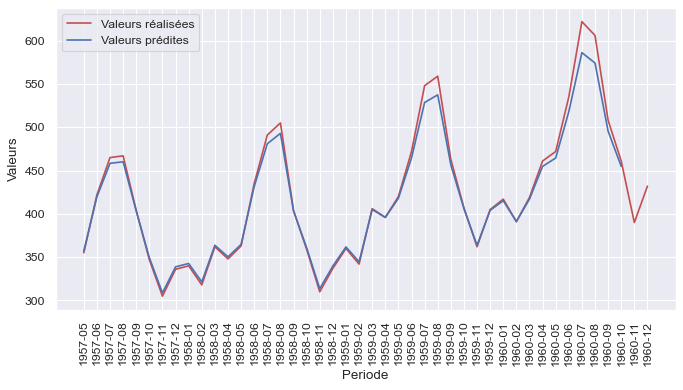

In [8]:
plt.figure(figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test['PASSENGERS'].values, color="r", label="Valeurs réalisées")
plt.plot(predicted, color="b", label="Valeurs prédites")
plt.xticks(range(test.shape[0]), labels=test['MONTH'], rotation='vertical')
plt.legend()
plt.xlabel("Periode")
plt.ylabel("Valeurs")
plt.grid(True)
plt.show()

**Références :**   
[CS 224D: Deep Learning for NLP1 ](https://cs224d.stanford.edu/lecture_notes/LectureNotes4.pdf)  
[AMAN KHARWAL, Time Series with LSTM in Machine Learning](https://thecleverprogrammer.com/2020/08/29/time-series-with-lstm-in-machine-learning/)  